In [1]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

%load_ext autoreload
%autoreload 2

In [2]:
humanseqs = [s for s in fasta_iter(human, returnheader=False)]


In [3]:
train, test = train_test_split(humanseqs, test_size=0.5)


In [6]:
k = 4


In [7]:
kmers = [''.join(s) for s in itertools.product(aminoacids, repeat=k)]
df = pd.DataFrame.from_dict(dict(seq=kmers, freq=np.zeros(len(kmers))))
df.set_index('seq', inplace=True)
df['freq'] = df.add(count(train, k), fill_value=0.0)
df['freq_test'] = np.zeros(len(kmers))
df['freq_test'] = df['freq_test'].add(count(test, k)['freq'], fill_value=0.0)
jsd_test = calc_jsd(df['freq_test'], df['freq'])
jsd_flat = calc_jsd(df['freq_test'], np.ones_like(df['freq']), base=2)


#df_test.set_index('seq', inplace=True)
#df_count = counter_to_df(count_kmers_iterable(test, k), norm=False)
#df_count.set_index('seq', inplace=True)
#df_test = df_test.add(df_count, fill_value=0.0)
#df_test['freq'] = df_test['count'] / np.sum(df_test['count'])


tripletparams = calc_tripletmodelparams(train)
#kmers = df.index
df['freq_ind'] = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
df['freq_mc'] = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
df['freq_tri'] = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
jsd_ind = calc_jsd(df['freq_test'], df['freq_ind'], base=2)
jsd_mc = calc_jsd(df['freq_test'], df['freq_mc'], base=2)
jsd_tri = calc_jsd(df['freq_test'], df['freq_tri'], base=2)

In [8]:
aacountss = []
#for seq in np.random.choice(humanseqs, 1000, replace=False):
for seq in train:
    seq = seq.strip('X')
    if not isvalidaa(seq):
        seq = re.sub('X|U', '', seq)
        if not isvalidaa(seq):
            print(seq)
    seq = map_aatonumber(seq)
    for i in range(len(seq)-k):
        #if isvalidaa(seq[i:i+k]):
        #print(seq[i:i+k], aacounts(seq[i:i+k]))
        aacountss.append(aacounts_int(seq[i:i+k]))

A 0.06972035254397053 [7.57393048e-01 2.09882702e-01 2.95552322e-02 2.78781255e-03
 3.81205276e-04]
C 0.022843102684972524 [9.13829972e-01 8.11273932e-02 4.89188283e-03 1.41740141e-04
 9.01199830e-06]
D 0.0476272678362107 [8.24808202e-01 1.60717668e-01 1.36800107e-02 7.45081385e-04
 4.90383703e-05]
E 0.07110607075311093 [7.55377174e-01 2.08989992e-01 3.19126296e-02 3.27176778e-03
 4.48435719e-04]
F 0.03690882044359964 [8.61708011e-01 1.29246197e-01 8.75226180e-03 2.89543151e-04
 3.98704251e-06]
G 0.06556454079267812 [7.68533029e-01 2.03353898e-01 2.56842835e-02 2.17944635e-03
 2.49343505e-04]
H 0.02624239867133237 [9.00113055e-01 9.50624620e-02 4.60459398e-03 1.81593239e-04
 3.82953614e-05]
I 0.043771004098804495 [8.38082575e-01 1.49228540e-01 1.22182684e-02 4.63510586e-04
 7.10598059e-06]
K 0.05726877189212979 [7.96646790e-01 1.79512735e-01 2.20628499e-02 1.67383183e-03
 1.03793061e-04]
L 0.10041100673257444 [6.59162613e-01 2.85213027e-01 5.07565604e-02 4.55330478e-03
 3.14494656e-04]

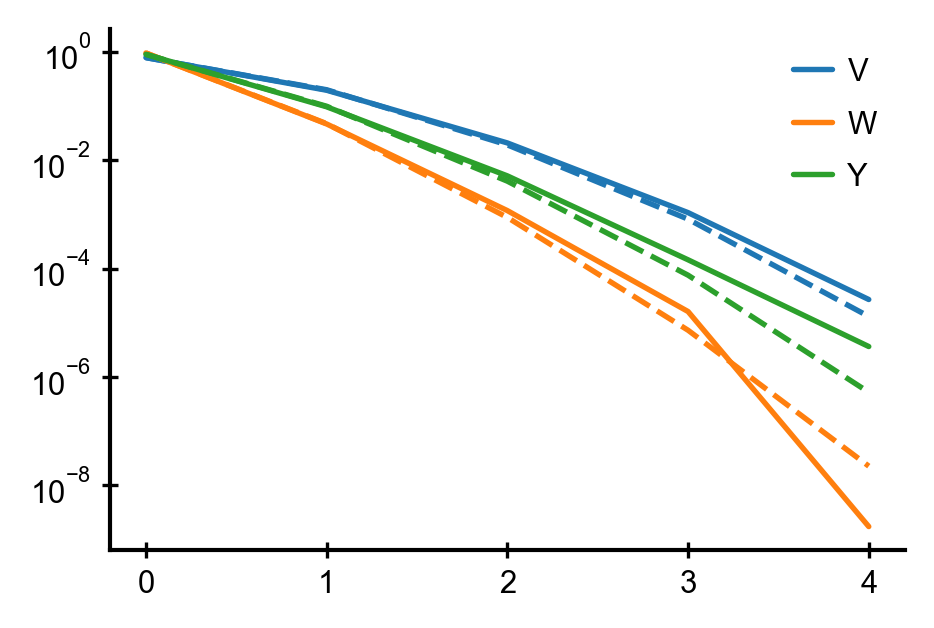

In [9]:
pseudocount = 1e-2
aafreqs = np.mean(np.asarray(aacountss), axis=0)/k
prob_aa_ks = prob_aa(aacountss, k, pseudocount=pseudocount)
for i in range(len(aminoacids)):
    aa = map_numbertoaa([i])[0]
    prob_aa_k = prob_aa_ks[i]
    print(aa, aafreqs[i], prob_aa_k)
    if i >16:
        l, = plt.plot(prob_aa_k, label=aa)
        x = np.arange(0, k+1, 1)
        n = k
        p = aafreqs[i]
        plt.plot(x, binom.pmf(x, n, p), '--', c=l.get_color())
plt.legend()
plt.yscale('log')
fks = np.asarray(prob_aa_ks)

In [10]:
for i, aa in enumerate(aminoacids):
    dist = scipy.stats.rv_discrete(values=(np.arange(k+1), prob_aa_ks[i]))
    print(aa, dist.var()/(dist.mean()*(1-dist.mean()/k)))

A 1.085109700967974
C 1.0501836842781322
D 1.028653055257551
E 1.1066018482339912
F 1.0206946248295172
G 1.0646887991946026
H 1.0244027624024779
I 1.0257558671704634
K 1.0743560570745991
L 1.032156007699662
M 1.0137188731566193
N 1.0200171104068345
P 1.1314179608014783
Q 1.0533779126031229
R 1.0676147274766012
S 1.0892723513943574
T 1.0267558865012723
V 1.0224676297413469
W 1.0132874203383413
Y 1.0242446147525897


In [11]:
# evaluate empirical observables for fitting
df0 = count(train, 1)
df1 = count(train, 2, gap=0)
dfgap1 = count(train, 2, gap=1)
if k == 4:
    dfgap2 = count(train, 2, gap=2)

In [12]:
args = [df1, dfgap1, dfgap2] if k == 4 else [df1, dfgap1]
h, Jk = fit_potts(df0, args, nmcmc=5e5, niter=10, epsilon=0.2, N=k, output=True)

[ 0.44746516 -0.66927156  0.06488325  0.46528148 -0.19050289  0.38355623
 -0.53138133 -0.02079074  0.25017281  0.80998859 -0.73103507 -0.21180513
  0.34233483  0.06704333  0.22998163  0.6195353   0.17771732  0.29710163
 -1.29180768 -0.50846716]
iteration 0
f1 4.476127273362751e-06
f2, gap 0 0.0024146260305523814
f2, gap 1 0.0018117193322767565
f2, gap 2 0.002019313740316058
iteration 1
f1 1.2584504711115676e-05
f2, gap 0 0.0015747695930211163
f2, gap 1 0.0011877504201717845
f2, gap 2 0.0013958006676574818
iteration 2
f1 1.120406752720984e-05
f2, gap 0 0.0010625495536692028
f2, gap 1 0.000772223791703597
f2, gap 2 0.0010109149612457348
iteration 3
f1 9.980313949829674e-06
f2, gap 0 0.0006979550782313768
f2, gap 1 0.0005821444345439923
f2, gap 2 0.0006670138354170465
iteration 4
f1 1.2166275274410422e-05
f2, gap 0 0.0005021279830033098
f2, gap 1 0.0004514366511976827
f2, gap 2 0.0005356060343491994
iteration 5
f1 8.28324569029826e-06
f2, gap 0 0.0003860064772410925
f2, gap 1 0.0003012936

In [14]:
Z = np.exp(scipy.special.logsumexp([-clib.energy(np.array(s), h, Jk) for s in itertools.product(range(naminoacids), repeat=k)]))
df['freq_maxent'] = np.exp([-clib.energy(map_aatonumber(s), h, Jk) for s in kmers])/Z
jsd_maxent = calc_jsd(df['freq_test'], df['freq_maxent'], base=2)

In [15]:
hks = fit_global(fks, niter=10, nmcmc=1e6, epsilon=0.1, output=True)

iteration 0
[2.90512334e-06 9.53816257e-05 6.47926451e-04 1.44376155e-02
 1.24333634e-01]
iteration 1
[2.75856055e-06 9.43912499e-05 7.23561702e-04 1.59741977e-02
 1.65529153e-01]
iteration 2
[2.60718043e-06 8.72245979e-05 6.53964603e-04 1.06421084e-02
 1.31269296e-01]
iteration 3
[2.54442038e-06 8.44896742e-05 8.72001408e-04 1.50421243e-02
 1.82890370e-01]
iteration 4
[2.17801555e-06 7.48453272e-05 7.04547413e-04 1.00884850e-02
 1.23185166e-01]
iteration 5
[1.81960943e-06 6.74847124e-05 6.53230829e-04 1.47243340e-02
 1.51058786e-01]
iteration 6
[1.76266499e-06 5.95955101e-05 6.93436030e-04 1.33729896e-02
 1.71697610e-01]
iteration 7
[1.78671962e-06 6.80359522e-05 8.79047080e-04 1.19240230e-02
 2.74568610e-01]
iteration 8
[1.45582555e-06 5.27958254e-05 6.72773626e-04 1.51166095e-02
 2.43349670e-01]
iteration 9
[1.56038815e-06 5.70676281e-05 7.51670642e-04 1.12625961e-02
 1.54369180e-01]


In [ ]:
pseudocount = 1e-2
niter=10
nmcmc=1e6
epsilon=0.5
prng=None
output=False

N = len(fks[0])-1
if prng is None:
    prng = np.random
q = len(aminoacids)
aas_arr = np.array(list(aminoacids))
f1 = np.sum(np.arange(fks.shape[1])*fks, axis=1)/(fks.shape[1]-1)
h = np.array(np.log(f1))
h -= np.mean(h)
hks = h.reshape(20, 1)*np.arange(fks.shape[1])
#hks = np.zeros((q, N+1))
for i in range(niter):
    if output:
        print('iteration %g'%i)
#    def jump(x):
#        xp = x.copy()
#        i = np.random.randint(0, len(x))
#        xp[i] = (xp[i]+np.random.randint(0, q-1))%q
#        return xp
    def jump(x):
        return prng.randint(q, size=N)
    def energy(x):
        return energy_global(aacounts_int(x), hks)
    x0 = jump(prng.randint(q, size=N))
    samples = mcmcsampler(x0, energy, jump, nmcmc, prng=prng, nburnin=1e3)
    aacountss = [aacounts_int(s) for s in samples]
    prob_aa_ks = prob_aa(aacountss, N, pseudocount=pseudocount)
    #Z = np.exp(scipy.special.logsumexp([-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]))
    #probs = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
    if i == 0:
        prob_aa_ks0 = prob_aa_ks
    hks += np.log(fks/prob_aa_ks)*epsilon
    #hks += (fks-prob_aa_ks)*epsilon
    jsd = calc_jsd(fks, prob_aa_ks, base=2)
    print(jsd)

In [ ]:
plt.plot(fks.flatten(), prob_aa_ks.flatten(), 'o')
x = [1e-6, 1e0]
plt.plot(x, x, 'k')
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(fks.flatten(), prob_aa_ks0.flatten()/fks.flatten(), 'o')
plt.plot(fks.flatten(), prob_aa_ks.flatten()/fks.flatten(), 'o')
#x = [1e-6, 1e0]
#plt.plot(x, x, 'k')
plt.axhline(1.0, c='k')
#plt.ylim(1e-1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
Z = np.exp(scipy.special.logsumexp(
           [-energy_global(aacounts_int(np.array(s)), hks) for s in itertools.product(range(naminoacids), repeat=k)]
           ))
df['freq_maxentglobal'] = np.exp([-energy_global(aacounts(s), hks) for s in kmers])/Z
jsd_maxentglobal = calc_jsd(df['freq_test'], df['freq_maxentglobal'], base=2)

In [ ]:
entropies = {}
Smax = np.log2(20)*k
for column in df.filter(regex='freq'):
    f3 = np.array(df[column])
    entropy = scipy.stats.entropy(f3, base=2)
    print(column, Smax-entropy)
    entropies[column] = entropy

In [ ]:
print('test', jsd_test, 'maxent', jsd_maxent, 'maxentglobal', jsd_maxentglobal,
              'flat', jsd_flat, 'ind', jsd_ind, 'mc', jsd_mc, 'tri', jsd_tri)

In [ ]:
from scipy.stats import gaussian_kde
def scatterplot(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x, y, c=z, s=1, edgecolor='')

In [ ]:
scatter = lambda x, y, ax: plotting.density_scatter(x, y, ax=ax, s=1, bins=100,
                                           trans=lambda x: np.log(x+1e-8),
                                           norm=matplotlib.colors.LogNorm(vmin=0.5, vmax=50 if k ==3 else 400),
                                           cmap='viridis')
#scatter = lambda x, y, ax: ax.scatter(x, y, s=1, alpha=1, edgecolor=None)

fig, axes = plt.subplots(figsize=(7.2, 2.0), ncols=5, sharex=True, sharey=True)
axes[0].set_ylabel('test set')

for ax, column, xlabel in [(axes[0], 'freq_ind','independent prediction'),
                           (axes[1], 'freq_maxentglobal', 'global maxent prediction'),
                           (axes[2], 'freq_mc', 'mc'),
                           (axes[3], 'freq_maxent', 'maxent prediction'),
                           (axes[4], 'freq', 'training set')
                            ]:
    scatter(df[column], df['freq_test'], ax)
    ax.set_xlabel(xlabel)
    jsd = calc_jsd(df['freq_test'], df[column], base=2)
    entropy = entropies[column]
    ax.set_title('JSD = {:.4f}\nH = {:.2f}'.format(jsd, entropy))
    
if k == 3:
    x = np.logspace(-5.7, -2.7)
elif k == 4:
    x = np.logspace(-7.7, -2.9)
for ax in axes:
    ax.plot(x, x, 'k', lw=0.8)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(x), max(x))
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.tight_layout()
fig.savefig('main.png' if k == 3 else 'comparison_k4.png', dpi=600)

In [ ]:
2**entropies['freq'], 2**entropies['freq_maxent'], 2**entropies['freq_ind'], 20**k

In [ ]:
bins = np.linspace(-6, -2)
kwargs = dict(bins=bins, histtype='step')
plt.hist(np.log10(df['freq_ind']), **kwargs)
plt.hist(np.log10(df['freq_maxent']),**kwargs)
plt.hist(np.log10(df['freq']),**kwargs)
plt.yscale('log')